<a href="https://colab.research.google.com/github/onlygoodman/dacon_-/blob/main/project_shop_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

001 - https://wikidocs.net/94600 네이버 쇼핑 리뷰 데이터 분석을 참조하여 0,1 긍부정 이진 분류를 통해 확률을 0~5로 확장하여 예측



In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 23.23 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 35.2 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-07-14 00:15:51--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c0:3470, 2406:da00:ff00::22cd:e0db, ...
Connecting to bitbucket.org (b

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Train dataset은 Label이 존재하지 않음
train_data = pd.read_csv("/content/drive/MyDrive/shopping_dataset/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/shopping_dataset/test.csv")
submit = pd.read_csv("/content/drive/MyDrive/shopping_dataset/sample_submission.csv")

In [5]:
train_data.head(10)

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5
5,5,배송은 먼저 구입하신 분들께서 오래걸린다고 하여 참고 기달렸습니다 생각보다 일찍도착...,2
6,6,타이밍이 좋았는지 배송도 빠르고 맛있었어요! 크기가 두가지가 있길래 큰걸 사봤는데 ...,5
7,7,상품 퀄리티가 좋지 않아요,2
8,8,재구매 평소 사용하던 제품이에요. 한번에 쟁여두려 여러개 삽니다 .,5
9,9,두께 때문에 별로네요..,2


In [12]:
def predata(data):
  data['label'] = np.select([data.target > 3], [1], default = 0)

  #혹시 중복이 있다면 제거
  data.drop_duplicates(subset=['reviews'], inplace=True)

In [13]:
predata(train_data)

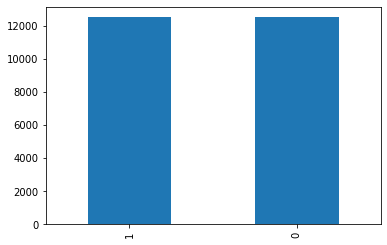

In [15]:
train_data['label'].value_counts().plot(kind='bar')

In [16]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  12499
1      1  12500


In [17]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id         0
reviews    0
target     0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [18]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 25000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [19]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
mecab = Mecab()

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [20]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [21]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 5241), ('안', 3373), ('는데', 3360), ('어요', 2568), ('있', 2222), ('너무', 2157), ('했', 1969), ('좋', 1623), ('배송', 1621), ('구매', 1553), ('거', 1511), ('같', 1478), ('없', 1471), ('어', 1441), ('되', 1434), ('아요', 1433), ('잘', 1374), ('그냥', 1373), ('습니다', 1355), ('않', 1278)]


In [22]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 6531), ('아요', 3515), ('네요', 3291), ('잘', 3190), ('어요', 3091), ('구매', 2670), ('습니다', 2311), ('있', 2145), ('배송', 1993), ('는데', 1957), ('먹', 1625), ('합니다', 1589), ('했', 1567), ('재', 1533), ('너무', 1434), ('같', 1365), ('만족', 1206), ('쓰', 1132), ('거', 1079), ('기', 1070)]


긍정 리뷰의 평균 길이 : 13.6924
부정 리뷰의 평균 길이 : 17.164893191455317


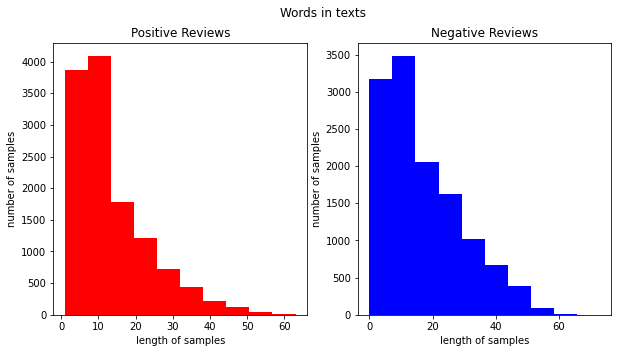

In [23]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [25]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values

In [26]:
#정수인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [27]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 17534
등장 빈도가 1번 이하인 희귀 단어의 수: 8171
단어 집합에서 희귀 단어의 비율: 46.60088970001141
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.1184913624354746


In [28]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 9365


In [29]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [30]:
print(X_train[:3])

[[359, 22, 152, 120, 175, 317, 4], [45, 35, 7, 10, 776, 1, 2535, 303, 897, 10, 392, 5, 75, 391, 176, 2417, 36, 1407, 13, 591, 2], [153, 85, 148, 89, 1279, 44, 188, 14, 5, 84, 76, 204, 59, 89, 1881, 8, 871, 1279, 4407, 8, 2, 91, 180, 47, 46, 23, 457, 12, 477, 271, 345, 185, 4]]


리뷰의 최대 길이 : 73
리뷰의 평균 길이 : 15.428577143085723


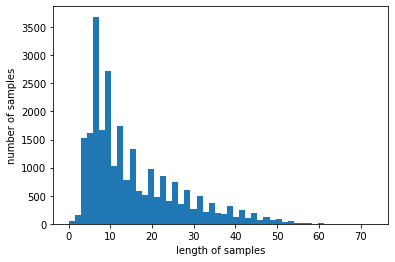

In [31]:
#패딩 작업

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [32]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [33]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.9519980799232


In [34]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [35]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 0.3632 - acc: 0.8515
Epoch 1: val_acc improved from -inf to 0.88040, saving model to best_model.h5
313/313 [==============================] - 43s 129ms/step - loss: 0.3632 - acc: 0.8515 - val_loss: 0.2977 - val_acc: 0.8804
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 0.2580 - acc: 0.9026
Epoch 2: val_acc improved from 0.88040 to 0.89420, saving model to best_model.h5
313/313 [==============================] - 37s 117ms/step - loss: 0.2580 - acc: 0.9026 - val_loss: 0.2711 - val_acc: 0.8942
Epoch 3/15
313/313 [==============================] - ETA: 0s - loss: 0.2280 - acc: 0.9171
Epoch 3: val_acc improved from 0.89420 to 0.89660, saving model to best_model.h5
313/313 [==============================] - 35s 112ms/step - loss: 0.2280 - acc: 0.9171 - val_loss: 0.2793 - val_acc: 0.8966
Epoch 4/15
313/313 [==============================] - ETA: 0s - loss: 0.2048 - acc: 0.9270
Epoch 4: val_acc improve

In [36]:
loaded_model = load_model('best_model.h5')

In [37]:
test_data.head()

,id,reviews,tokenized
0,0,채소가 약간 시들어 있어요,"[채소, 약간, 시들, 어, 있, 어요]"
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...,"[발톱, 두껍, 단단, 분, 써도, 소용없, 어요, 테이프, 물렁, 거리, 힘, 없..."
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요,"[부들부들, 좋, 네요, 입, 어, 보, 시원, 면, 또, 살, 게요]"
3,3,이런 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임,"[이런, 골드, 주라, 니깐, 파란, 개, 오, 회사, 전화, 걸어도, 받, 않, ..."
4,4,검수도 없이 보내구 불량 배송비 원 청구하네요 완전별로 별하나도 아까워요,"[검수, 없이, 보내, 구, 불량, 배송, 비, 원, 청구, 네요, 완전, 별, 로..."


In [42]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  star_score = int(score*100)//20+1

  return star_score

In [43]:
test_sen = test_data.reviews

pred = []

for sentence in test_sen:
  pred.append(sentiment_predict(sentence))

In [44]:
submit["target"] = pred
submit.head() 
submit.to_csv("submission.csv",index=False)

In [45]:
submit.head()

,id,target
0,0,4
1,1,1
2,2,5
3,3,1
4,4,1
